# Home Work 2. 
### Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

### Исходные данные

In [1]:
import pandas as pd

Наши новости

In [2]:
news = pd.read_csv("Data/articles.csv")
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [3]:
users = pd.read_csv("Data/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

#### Получаем векторные представления новостей

In [4]:
#!pip install gensim
#!pip install razdel
#!pip install pymorphy2

In [5]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [6]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
#from nltk.tokenize import word_tokenize

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

In [7]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [8]:
with open('Data/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [9]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [10]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


Wall time: 31.9 s


In [11]:
%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

Wall time: 4min 52s


А теперь в 3 строчки обучим нашу модель

In [12]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [13]:
common_dictionary[100]

'выбросить'

Все просто - это словарь наших слов

Запускаем обучение

In [14]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

Wall time: 56.9 s


In [15]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [16]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(6, 0.100293845),
 (10, 0.026386045),
 (14, 0.5300104),
 (16, 0.042979013),
 (21, 0.16480663),
 (23, 0.11857092)]

In [17]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: мышь орден вклад дания отечество зао выражение
topic_1: журнал вирус параметр эксперимент статья минск свердловский
topic_2: который орган сотрудник год власть произойти компания
topic_3: эксперимент чиновник задержать полиция источник полицейский сотрудник
topic_4: украина украинский год киев страна это общество
topic_5: газ фестиваль теория израиль мэй израильский потенциально
topic_6: военный сша американский операция это новый год
topic_7: nn программа мероприятие дональд пройти форум палата
topic_8: китай рак китайский обращение рейтинг место смерть
topic_9: квартира отряд сократиться оборудование автобус армения праздничный
topic_10: физика способность широко шкала оаэ необычно лечиться
topic_11: фонд технология век спрос инвестиция реформа северный
topic_12: сообщество индия золото негативно золотой японец белорусский
topic_13: россия страна президент российский путин nn эксперт
topic_14: следствие лётчик знаменитый тур снг задать химия
topic_15: это который земля год и

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [18]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [19]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.095961,0.0,...,0.0,0.000000,0.435632,0.247997,0.0,0.0,0.120426,0.0,0.000000,0.000000
1,4896,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.238760,0.0,0.000000,0.250383
2,4897,0.0,0.0,0.0,0.0,0.0,0.0,0.100242,0.000000,0.0,...,0.0,0.042998,0.000000,0.000000,0.0,0.0,0.166790,0.0,0.116524,0.000000
3,4898,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.820912,0.0,0.000000,0.000000
4,4899,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.851060,0.0,0.0,0.000000,0.0,0.000000,0.000000


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

#### Следующий шаг - векторные представления пользователей

In [20]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [21]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [22]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.19814622, 0.        , 0.        ,
       0.        , 0.        , 0.01731119, 0.04548019, 0.        ,
       0.        , 0.3288008 , 0.        , 0.14026709, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.25846133])

In [23]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.mean(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [24]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.093387,0.014802,0.078834,0.000000,0.050018,0.066821,0.000000,...,0.019670,0.141113,0.016377,0.122392,0.012627,0.0,0.035102,0.015620,0.010611,0.231216
1,u108690,0.0,0.0,0.078159,0.012308,0.072198,0.000000,0.043303,0.012461,0.000000,...,0.081080,0.089567,0.003893,0.116640,0.000000,0.0,0.085119,0.004021,0.049078,0.164320
2,u108339,0.0,0.0,0.128931,0.009736,0.005729,0.003999,0.052563,0.021007,0.020678,...,0.128271,0.060774,0.008653,0.236838,0.000000,0.0,0.017293,0.038320,0.046031,0.117894


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [25]:
target = pd.read_csv("Data/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [26]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.093387,0.014802,0.078834,0.000000,0.050018,0.066821,0.000000,...,0.141113,0.016377,0.122392,0.012627,0.0,0.035102,0.015620,0.010611,0.231216,0
1,u108690,0.0,0.0,0.078159,0.012308,0.072198,0.000000,0.043303,0.012461,0.000000,...,0.089567,0.003893,0.116640,0.000000,0.0,0.085119,0.004021,0.049078,0.164320,1
2,u108339,0.0,0.0,0.128931,0.009736,0.005729,0.003999,0.052563,0.021007,0.020678,...,0.060774,0.008653,0.236838,0.000000,0.0,0.017293,0.038320,0.046031,0.117894,1


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [28]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [29]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [30]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.14163655, 0.27985664, 0.46674324, 0.14006515, 0.05199694,
       0.05437759, 0.12727707, 0.04394904, 0.15462744, 0.12097825])

In [31]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

#### Рассчитаем Precision, Recall, F_score

In [32]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.253371, F-Score=0.711, Precision=0.665, Recall=0.763


In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1661   94]
 [  59  186]]


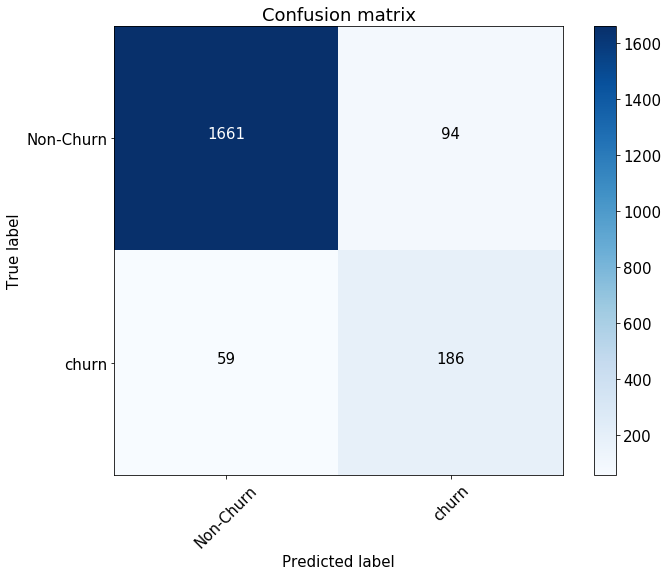

In [34]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

In [35]:
roc_auc_score(y_test, preds)

0.9499738356881213

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

In [36]:
roc_auc_mean, precision_mean, recall_mean = roc_auc_score(y_test, preds), precision, recall
f_score_mean = 2 * (precision * recall) / (precision + recall)

## Задание 1.  
#### Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)

In [37]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.median(user_vector, 0)
    return user_vector

In [38]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.066655,0.0,0.000000,0.0,0.039907,0.000000,0.0,...,0.000000,0.140378,0.0,0.142933,0.0,0.0,0.000000,0.000000,0.000000,0.219077
1,u108690,0.0,0.0,0.060923,0.0,0.044031,0.0,0.007138,0.000000,0.0,...,0.072303,0.073985,0.0,0.120124,0.0,0.0,0.054675,0.000000,0.058032,0.125147
2,u108339,0.0,0.0,0.124936,0.0,0.000000,0.0,0.033057,0.010711,0.0,...,0.131559,0.064930,0.0,0.271891,0.0,0.0,0.000000,0.027708,0.026450,0.094439


Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [39]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.066655,0.0,0.000000,0.0,0.039907,0.000000,0.0,...,0.140378,0.0,0.142933,0.0,0.0,0.000000,0.000000,0.000000,0.219077,0
1,u108690,0.0,0.0,0.060923,0.0,0.044031,0.0,0.007138,0.000000,0.0,...,0.073985,0.0,0.120124,0.0,0.0,0.054675,0.000000,0.058032,0.125147,1
2,u108339,0.0,0.0,0.124936,0.0,0.000000,0.0,0.033057,0.010711,0.0,...,0.064930,0.0,0.271891,0.0,0.0,0.000000,0.027708,0.026450,0.094439,1


In [40]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [41]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [42]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16597445, 0.14333185, 0.62885789, 0.16806476, 0.02079923,
       0.02833975, 0.14728401, 0.08618809, 0.14230022, 0.18981945])

#### Рассчитаем Precision, Recall, F_score

In [43]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.291210, F-Score=0.773, Precision=0.775, Recall=0.771


Confusion matrix, without normalization
[[1700   55]
 [  57  188]]


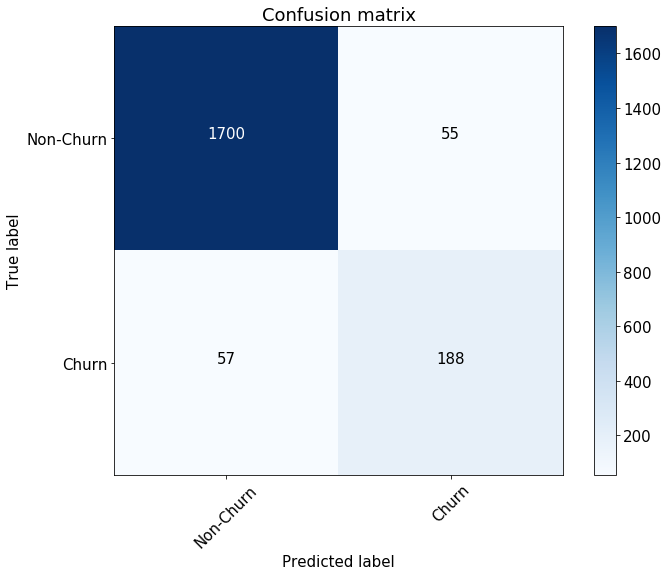

In [44]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'Churn'],
                      title='Confusion matrix')
#plt.savefig("conf_matrix.png")
plt.show()

In [45]:
roc_auc_median, precision_median, recall_median = roc_auc_score(y_test, preds), precision, recall
f_score_median = 2 * (precision * recall) / (precision + recall)

## Задание 2. 
#### Повторить предыдущее задание, но используя уже не медиану, а max.

In [46]:
def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = np.max(user_vector, 0)
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [47]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.0,0.0,0.262887,0.088809,0.473002,0.000000,0.132367,0.202782,0.000000,...,0.118021,0.328801,0.098264,0.226293,0.075764,0.0,0.176254,0.071183,0.063669,0.567900
1,u108690,0.0,0.0,0.196547,0.073846,0.216150,0.000000,0.213117,0.048172,0.000000,...,0.163795,0.208881,0.023360,0.251159,0.000000,0.0,0.249888,0.024126,0.073991,0.375175
2,u108339,0.0,0.0,0.191706,0.036813,0.034375,0.023992,0.142252,0.080068,0.104398,...,0.216983,0.112622,0.051919,0.309397,0.000000,0.0,0.071659,0.111833,0.153389,0.295104


In [48]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.0,0.0,0.262887,0.088809,0.473002,0.000000,0.132367,0.202782,0.000000,...,0.328801,0.098264,0.226293,0.075764,0.0,0.176254,0.071183,0.063669,0.567900,0
1,u108690,0.0,0.0,0.196547,0.073846,0.216150,0.000000,0.213117,0.048172,0.000000,...,0.208881,0.023360,0.251159,0.000000,0.0,0.249888,0.024126,0.073991,0.375175,1
2,u108339,0.0,0.0,0.191706,0.036813,0.034375,0.023992,0.142252,0.080068,0.104398,...,0.112622,0.051919,0.309397,0.000000,0.0,0.071659,0.111833,0.153389,0.295104,1


In [49]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(25)]], 
                                                    X['churn'], random_state=0)

In [50]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [51]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.23013066, 0.03973493, 0.67592041, 0.04872875, 0.02169877,
       0.01356837, 0.02695999, 0.01804923, 0.03621853, 0.22303356])

#### Рассчитаем Precision, Recall, F_score

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.361642, F-Score=0.800, Precision=0.800, Recall=0.800


Confusion matrix, without normalization
[[1706   49]
 [  50  195]]


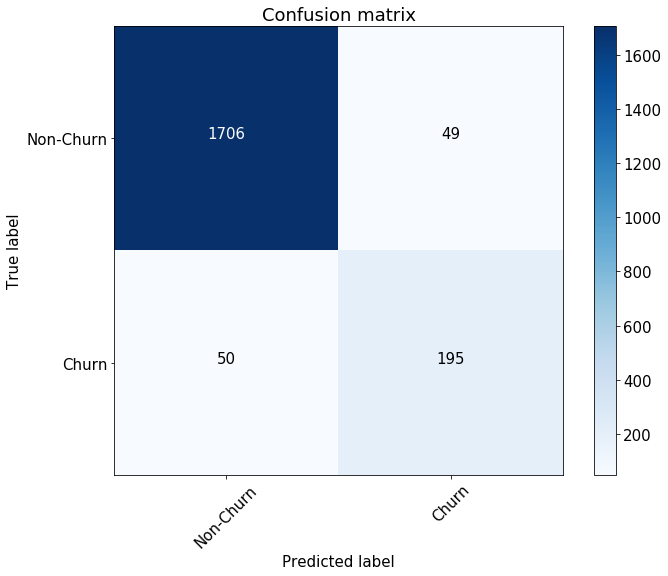

In [53]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'Churn'],
                      title='Confusion matrix')
#plt.savefig("Data/conf_matrix_max.png")
plt.show()

In [54]:
roc_auc_max, precision_max, recall_max = roc_auc_score(y_test, preds), precision, recall
f_score_max = 2 * (precision * recall) / (precision + recall)

In [55]:
def df_highlight_max(s):
    '''
    highlight the maximum
    '''
    is_max = s == s.max()
    return ['color: blue' if v else '' for v in is_max]

def df_bold_max(s):
    '''
    bold the maximum
    '''
    is_max = s == s.max()
    return ['font-weight: bold' if v else '' for v in is_max]

metrics = ['roc_auc',
           'precision',
           'recall',
           'f_score']
metrics_types = ['mean',
                 'median',
                 'max']

models_acccuracy = pd.DataFrame(columns=metrics_types)
for col in metrics_types:
    for row in metrics:
        models_acccuracy.loc[row, col] = np.mean(eval(f'{row}_{col}'))
print('Сравнение качества получившихся данных\nпо столбцам -- метод,\nпо строкам -- метрика,\n\
цветом -- наилучшее значение\n')
models_acccuracy.style.apply(df_highlight_max, axis=1).apply(df_bold_max, axis=1)

Сравнение качества получившихся данных
по столбцам -- метод,
по строкам -- метрика,
цветом -- наилучшее значение



,mean,median,max
roc_auc,0.949974,0.969140,0.966447
precision,0.471565,0.657224,0.492338
recall,0.817335,0.730761,0.846250
f_score,0.508193,0.606408,0.527892
